In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/MyDrive/Colab Notebooks/BiodivBERT-RE


In [4]:
import os

In [5]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "euadr")
print(root_data_dir)

dataset = "train"
csv_file_path = "train.csv"

offline_model_file = os.path.join(root_dir, "BiLSTM-euadr-model")
training_history_csv = "training_history.csv"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/euadr


## Util

In [6]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [7]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [8]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

## Dataset Preprocessing


In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col)
  data = data.fillna(method="ffill")
  return data

In [11]:
data_train = loadData(csv_file_path='train.csv', header=0, index_col=None)

In [12]:
data_train.head(10)

,sentence,label
0,"In humans, loss-of-function of the cilia-centr...",1
1,Toll-like receptor-induced @GENE$ secretion is...,1
2,"In summary, we observed associations between @...",1
3,A recent study demonstrated the association of...,1
4,"Based on @GENE$ analyses, 41 @DISEASE$ patient...",0
5,To study the (functional) relevance of single ...,0
6,Single nucleotide polymorphisms (SNPs) in the ...,1
7,The TIMP-1 genotype TT in women and T in men a...,1
8,Association between donor @GENE$ and graft sur...,1
9,"For the remaining markers, a susceptibility ro...",0


In [13]:
data_test = loadData(csv_file_path='test.csv', header=0, index_col=None)

In [14]:
data_test.head(10)

,sentence,label
0,@GENE$ is a calcification inhibitor and correl...,1
1,"Individual LOXL1 SNPs, @GENE$, rs3825942, and ...",1
2,Two hundred and twenty-three incident @DISEASE...,0
3,VEGF was expressed in 60% and @GENE$ in 39% of...,1
4,@DISEASE$ is associated with decreased express...,1
5,We observed that the @GENE$ allele is associat...,1
6,@GENE$ contribute to the development of @DISEA...,1
7,Our previous study demonstrated that expressio...,1
8,"Recently, mutations have been identified in th...",0
9,We genotyped the four single-nucleotide polymo...,0


In [15]:
data_dev = loadData(csv_file_path='dev.csv', header=0, index_col=None)

In [16]:
data_dev.head(10)

,sentence,label
0,"On multivariate analysis the @GENE$ (OR 8.205,...",1
1,Overall and relapse-free survival in @DISEASE$...,1
2,The HBS1L-MYB intergenic region on chromosome ...,0
3,The @GENE$ SNP could be considered as a geneti...,0
4,Lysophosphatidic acid facilitates proliferatio...,0
5,Fetal haemoglobin (@GENE$) level modifies the ...,1
6,@GENE$ (HbF) level modifies the clinical sever...,1
7,Cutting edge: A common polymorphism impairs ce...,1
8,The @GENE$ polymorphism of COL1A2 could be a g...,1
9,Overall and relapse-free survival in oropharyn...,1


In [17]:
print(len(data_train), len(data_test), len(data_dev))

284 35 36


### Sentences 

In [18]:
train_texts = data_train[data_train.columns[0]].to_list()
train_labels = data_train[data_train.columns[1]].to_list()

In [19]:
test_texts = data_test[data_test.columns[0]].to_list()
test_labels = data_test[data_test.columns[1]].to_list()

In [20]:
dev_texts = data_dev[data_dev.columns[0]].to_list()
dev_labels = data_dev[data_dev.columns[1]].to_list()

#### Exploration

In [21]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

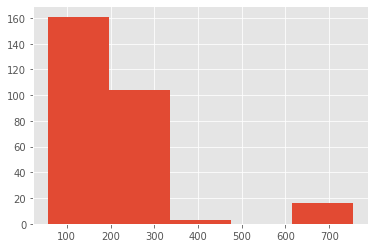

In [22]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [23]:
max([len(s) for s in train_texts])

754

In [24]:
max_len = 128 #selected value outisde the histogram

In [25]:
vocab_txt = []
vocab_txt.extend(train_texts)
print(len(vocab_txt))
vocab_txt.extend(test_texts)
print(len(vocab_txt))
vocab_txt.extend(dev_texts)
print(len(vocab_txt))

284
319
355


In [26]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab_txt)
print("The document count", tokenizer.document_count)
print("The count of words", tokenizer.word_counts)
print("The word index", tokenizer.word_index)

The document count 355
The count of words OrderedDict([('in', 347), ('humans', 5), ('loss', 4), ('of', 388), ('function', 6), ('the', 471), ('cilia', 4), ('centrosomal', 3), ('protein', 13), ('gene', 469), ('is', 60), ('associated', 76), ('with', 180), ('joubert', 2), ('and', 450), ('disease', 401), ('whereas', 3), ('hypomorphic', 4), ('mutations', 14), ('result', 5), ('leber', 2), ('congenital', 2), ('amaurosis', 2), ('lca', 3), ('a', 179), ('form', 4), ('early', 5), ('onset', 8), ('retinal', 3), ('dystrophy', 3), ('toll', 2), ('like', 4), ('receptor', 23), ('induced', 15), ('secretion', 16), ('impaired', 16), ('by', 49), ('nucleotide', 40), ('oligomerization', 8), ('domain', 8), ('2', 50), ('dependent', 16), ('independent', 13), ('pathways', 6), ('summary', 2), ('we', 32), ('observed', 15), ('associations', 8), ('between', 28), ('bc', 5), ('risk', 53), ('comprehensive', 2), ('analysis', 17), ('using', 10), ('clinical', 20), ('tumour', 6), ('characteristics', 2), ('as', 33), ('outcome

In [28]:
n_words = len(tokenizer.word_index.keys())

In [29]:
n_words

1359

In [30]:
len(train_texts)

284

### X & Y Prep

In [31]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(txts, lbls):
  sequences = tokenizer.texts_to_sequences(txts)
  X = pad_sequences(maxlen=max_len, sequences=sequences, padding="post", truncating="post")
  # X = tokenizer.sequences_to_matrix(X)
  y = np.array(lbls)
  # y = np.array([to_categorical(i, num_classes=2) for i in y])
  print(X.shape)
  print(X[0:3])
  print(y.shape)
  print(y[0:3])
  return X, y

In [32]:
X_train, y_train = getXYFromSentences(train_texts, train_labels)

(284, 128)
[[  6 332 406   5 292   5   1 407 530 163   2  21  15   7 634   3   4 531
  408 156 333   6 635 636 637 532   8 409   5 334 231 533 534   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [638 410  67 147   2 125  21 126   6   4  27  34 232 233  25 127   3 164
  293   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   

In [33]:
X_dev, y_dev = getXYFromSentences(dev_texts, dev_labels)

(36, 128)
[[  53 1276   92    1    2   13   59 1277   71   80   10 1278  262 1279
    14   11  935    3 1280 1281    5  602 1282   13   11 1283   71   80
    11 1284   11 1285   14   11  935   19  164  388   12    4 1286   79
    13 1287 1288    1 1289    5  405    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 627    3  936  573  338    6    4    3  628  616  401  617   52   15
     7   77    5    2    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0

In [34]:
X_test, y_test = getXYFromSentences(test_texts, test_labels)

(35, 128)
[[   2   21    8 1247  923    3 1248 1249    7  251    4    6  920   22
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 363  615   29    2  552    3  464   19   76   15    7    4    6    1
   154   32    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0

## BiLSTM Model

In [35]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [36]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1))(model)
  model = Dropout(rate=0.25)(model)
  model = Dense(512, activation='relu')(model)  
  model = Dropout(rate=0.25)(model)
  out = Dense(1,  activation='sigmoid')(model)  # segmoid output layer (binary classification)
  
  return Model(input, out)

In [37]:
model = create_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 50)           67950     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0   

In [39]:
from tensorflow.keras.losses import BinaryCrossentropy

In [40]:
model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='sum_over_batch_size'), metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])


Train on 284 samples, validate on 36 samples
Epoch 1/10
284/284 [==============================] - 3s 12ms/step - loss: 0.6031 - accuracy: 0.6866 - val_loss: 0.7594 - val_accuracy: 0.7222
Epoch 2/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5658 - accuracy: 0.7359 - val_loss: 0.5926 - val_accuracy: 0.7222
Epoch 3/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5026 - accuracy: 0.7465 - val_loss: 0.6015 - val_accuracy: 0.7222
Epoch 4/10
284/284 [==============================] - 2s 7ms/step - loss: 0.4128 - accuracy: 0.8239 - val_loss: 0.8899 - val_accuracy: 0.7222
Epoch 5/10
284/284 [==============================] - 2s 7ms/step - loss: 0.3726 - accuracy: 0.8275 - val_loss: 0.6684 - val_accuracy: 0.6667
Epoch 6/10
284/284 [==============================] - 2s 6ms/step - loss: 0.3370 - accuracy: 0.8345 - val_loss: 0.7357 - val_accuracy: 0.6944
Epoch 7/10
284/284 [==============================] - 2s 7ms/step - loss: 0.3128 - accuracy: 0.8732 -

In [43]:
save_model(model)

Saved model to disk


In [44]:
hist = pd.DataFrame(history.history)

In [45]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

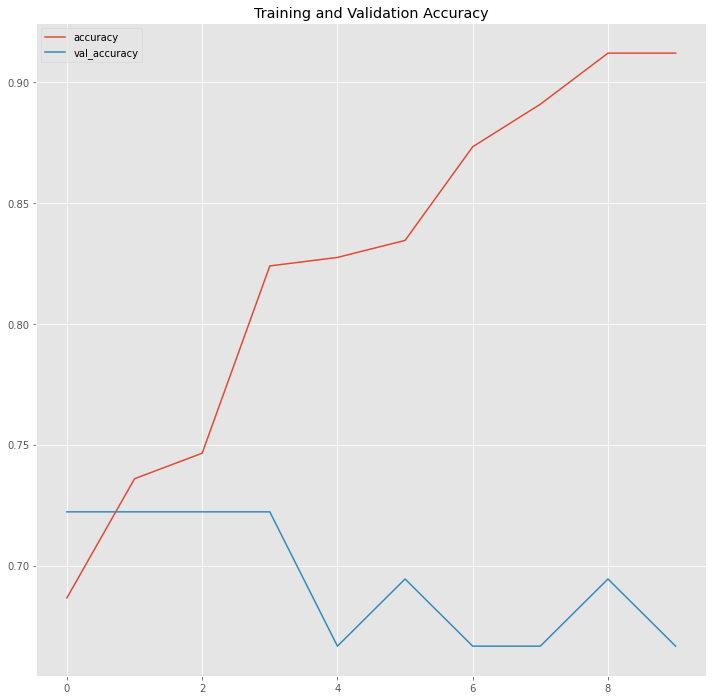

In [46]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluation

In [47]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

35/35 [==============================] - 0s 5ms/step


[0.7387867927551269, 0.800000011920929]

In [48]:
test_pred = model.predict(X_test, verbose=1)

35/35 [==============================] - 0s 9ms/step


In [49]:
pred_labels = [ 1 if t >= 0.5 else 0 for t in test_pred]

In [50]:
test_pred[0:10]

array([[0.918664  ],
       [0.5917058 ],
       [0.18121982],
       [0.9893353 ],
       [0.95879054],
       [0.9996673 ],
       [0.99440134],
       [0.9987055 ],
       [0.94878   ],
       [0.11504   ]], dtype=float32)

In [51]:
pred_labels[0:10]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 0]

In [52]:
test_labels[0:10]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]

In [53]:
from classification_metrics import classification_report, replaceMultiple

In [54]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.57		 0.50		 0.53		 8	
                   1	 0.86		 0.89		 0.87		 27	


macro avg           	 0.71		 0.69		 0.70		 35	
micro avg           	 0.80		 0.80		 0.80		 35	

